In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [4]:
#Preprocessing and Feature Engineering
merged_df = transactions_df.merge(customers_df, on='CustomerID')
merged_df


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00761,C0199,P022,2024-10-01 05:57:09,4,550.16,137.54,Andrea Jenkins,Europe,2022-12-03
2,T00626,C0199,P079,2024-08-17 12:06:08,2,834.74,417.37,Andrea Jenkins,Europe,2022-12-03
3,T00963,C0199,P008,2024-10-26 00:01:58,2,293.70,146.85,Andrea Jenkins,Europe,2022-12-03
4,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
...,...,...,...,...,...,...,...,...,...,...
995,T00774,C0095,P056,2024-01-07 14:19:49,2,32.16,16.08,William Walker,South America,2023-03-04
996,T00823,C0095,P079,2024-09-30 10:45:06,3,1252.11,417.37,William Walker,South America,2023-03-04
997,T00369,C0151,P082,2024-12-24 11:40:24,4,223.96,55.99,Amber Gonzalez,South America,2024-11-22
998,T00809,C0078,P075,2024-12-09 11:44:44,2,995.52,497.76,Julia Palmer,Asia,2024-11-13


In [7]:
customer_data = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionDate': 'count'
}).reset_index()
customer_data = customer_data.merge(customers_df, on='CustomerID')
features = ['TotalValue', 'Quantity', 'TransactionDate'] 
X = customer_data[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [9]:
# Function performing clustering and evaluation
def perform_clustering(algorithm, n_clusters, X_scaled):
    if algorithm == 'KMeans':
        model = KMeans(n_clusters=n_clusters, random_state=42)
    elif algorithm == 'DBSCAN':
        model = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters as needed
    else:
        raise ValueError("Invalid clustering algorithm")

    labels = model.fit_predict(X_scaled)

    silhouette = silhouette_score(X_scaled, labels)
    db_index = davies_bouldin_score(X_scaled, labels)

    return labels, silhouette, db_index

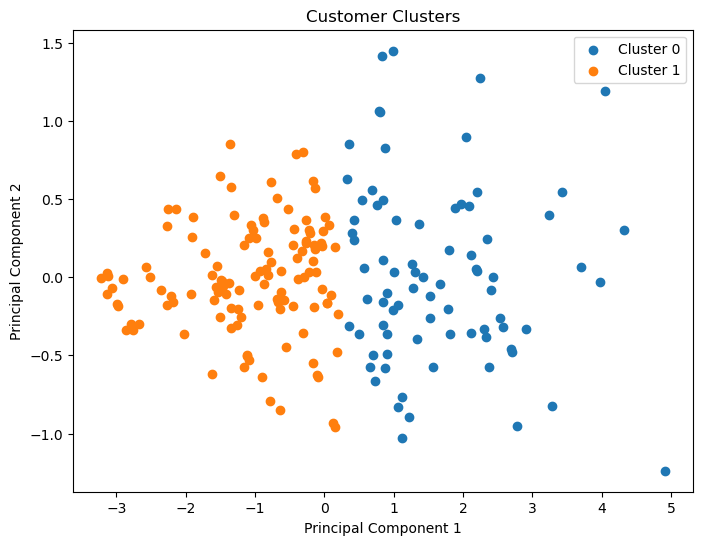

Best Clustering Algorithm: KMeans
Number of Clusters: 2
Davies-Bouldin Index: 0.7233652695141877
Silhouette Score: 0.49487297008885417


In [17]:
algorithms = ['KMeans', 'DBSCAN']  # Add other algorithms as needed
n_clusters_range = range(2, 11)

best_algorithm = None
best_n_clusters = None
best_db_index = float('inf')
best_silhouette = -1

for algorithm in algorithms:
    for n_clusters in n_clusters_range:
        labels, silhouette, db_index = perform_clustering(algorithm, n_clusters, X_scaled)

        if db_index < best_db_index:
            best_algorithm = algorithm
            best_n_clusters = n_clusters
            best_db_index = db_index
            best_silhouette = silhouette

# Performing clustering with the best configuration
labels, _, _ = perform_clustering(best_algorithm, best_n_clusters, X_scaled)

# Adding cluster labels to the dataframe
customer_data['Cluster'] = labels

# Visualizing clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for cluster in range(best_n_clusters):
    plt.scatter(X_pca[labels == cluster, 0], X_pca[labels == cluster, 1], label=f'Cluster {cluster}')

plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Clusters')
plt.show()

# Print clustering results
print(f"Best Clustering Algorithm: {best_algorithm}")
print(f"Number of Clusters: {best_n_clusters}")
print(f"Davies-Bouldin Index: {best_db_index}")
print(f"Silhouette Score: {best_silhouette}")
